http://d2l.ai/chapter_recurrent-neural-networks/language-models-and-dataset.html

In [1]:
from d2l import torch as d2l
import torch
import random

tokens = d2l.tokenize(d2l.read_time_machine())
vocab = d2l.Vocab(tokens)
print(vocab.token_freqs[:10])

[('the', 2261), ('', 1282), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816), ('to', 695), ('was', 552), ('in', 541), ('that', 443)]


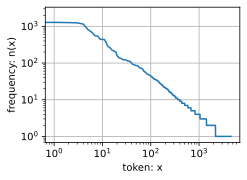

In [2]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

In [3]:
bigram_tokens = [[pair for pair in zip(
    line[:-1], line[1:])] for line in tokens]
bigram_vocab = d2l.Vocab(bigram_tokens)
print(bigram_vocab.token_freqs[:10])

[(('of', 'the'), 297), (('in', 'the'), 161), (('i', 'had'), 126), (('and', 'the'), 104), (('i', 'was'), 104), (('the', 'time'), 97), (('it', 'was'), 94), (('to', 'the'), 81), (('as', 'i'), 75), (('of', 'a'), 69)]


In [4]:
trigram_tokens = [[triple for triple in zip(line[:-2], line[1:-1], line[2:])]
                  for line in tokens]
trigram_vocab = d2l.Vocab(trigram_tokens)
print(trigram_vocab.token_freqs[:10])

[(('the', 'time', 'traveller'), 53), (('the', 'time', 'machine'), 24), (('the', 'medical', 'man'), 22), (('it', 'seemed', 'to'), 14), (('it', 'was', 'a'), 14), (('i', 'began', 'to'), 13), (('i', 'did', 'not'), 13), (('i', 'saw', 'the'), 13), (('here', 'and', 'there'), 12), (('i', 'could', 'see'), 12)]


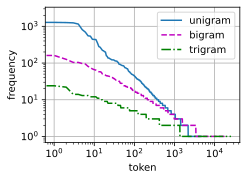

In [5]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token',
         ylabel='frequency', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

In [6]:
#@save
def seq_data_iter_random(corpus, batch_size, num_steps):
    # Offset the iterator over the data for uniform starts
    corpus = corpus[random.randint(0, num_steps):]
    # Subtract 1 extra since we need to account for label
    num_examples = ((len(corpus) - 1) // num_steps)
    example_indices = list(range(0, num_examples * num_steps, num_steps))
    random.shuffle(example_indices)

    def data(pos):
        # This returns a sequence of length `num_steps` starting from `pos`
        return corpus[pos: pos + num_steps]

    # Discard half empty batches
    num_batches = num_examples // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # `batch_size` indicates the random examples read each time
        batch_indices = example_indices[i:(i+batch_size)]
        X = [data(j) for j in batch_indices]
        Y = [data(j + 1) for j in batch_indices]
        yield torch.Tensor(X), torch.Tensor(Y)

In [7]:
my_seq = list(range(30))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=6):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 5.,  6.,  7.,  8.,  9., 10.],
        [11., 12., 13., 14., 15., 16.]]) 
Y: tensor([[ 6.,  7.,  8.,  9., 10., 11.],
        [12., 13., 14., 15., 16., 17.]])
X:  tensor([[17., 18., 19., 20., 21., 22.],
        [23., 24., 25., 26., 27., 28.]]) 
Y: tensor([[18., 19., 20., 21., 22., 23.],
        [24., 25., 26., 27., 28., 29.]])


In [8]:
#@save
def seq_data_iter_consecutive(corpus, batch_size, num_steps):
    # Offset for the iterator over the data for uniform starts
    offset = random.randint(0, num_steps)
    # Slice out data: ignore `num_steps` and just wrap around
    num_indices = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.Tensor(corpus[offset:offset+num_indices])
    Ys = torch.Tensor(corpus[offset+1:offset+1+num_indices])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_batches * num_steps, num_steps):
        X = Xs[:, i:(i+num_steps)]
        Y = Ys[:, i:(i+num_steps)]
        yield X, Y

In [9]:
for X, Y in seq_data_iter_consecutive(my_seq, batch_size=2, num_steps=6):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 6.,  7.,  8.,  9., 10., 11.],
        [17., 18., 19., 20., 21., 22.]]) 
Y: tensor([[ 7.,  8.,  9., 10., 11., 12.],
        [18., 19., 20., 21., 22., 23.]])


In [10]:
#@save
class SeqDataLoader:
    """A iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_consecutive
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [11]:
#@save
def load_data_time_machine(batch_size, num_steps, use_random_iter=False,
                           max_tokens=10000):
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab